In [1]:
%store -r data
%store -r ppl
%store -r df_countrymax

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime as dt

In [3]:
from sklearn.preprocessing import LabelEncoder

In [4]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [5]:
df=data.copy()
print(df.shape)
df.head()

(7926, 8)


,date,country,prov_state,country_prov,confirmed,deaths,recovered,active
SNo,,,,,,,,
1,01/22/2020,China,Anhui,China_Anhui,1,0,0,1
2,01/22/2020,China,Beijing,China_Beijing,14,0,0,14
3,01/22/2020,China,Chongqing,China_Chongqing,6,0,0,6
4,01/22/2020,China,Fujian,China_Fujian,1,0,0,1
5,01/22/2020,China,Gansu,China_Gansu,0,0,0,0


In [6]:
df.date=pd.to_datetime(df.date)

### Labelling day, month and date

In [7]:
lb=LabelEncoder()
df['date_code']=lb.fit_transform(df.date)
df['country_code']=lb.fit_transform(df.country_prov)
df['day']=df.date.dt.day
df['month']=df.date.dt.month

In [8]:
df.iloc[::1000,:]

,date,country,prov_state,country_prov,confirmed,deaths,recovered,active,date_code,country_code,day,month
SNo,,,,,,,,,,,,
1,2020-01-22,China,Anhui,China_Anhui,1,0,0,1,0,61,22,1
1001,2020-02-08,China,Liaoning,China_Liaoning,105,0,8,97,17,79,8,2
2001,2020-02-21,Spain,,Spain_,2,0,2,0,30,237,21,2
3001,2020-03-02,Lebanon,,Lebanon_,13,0,0,13,40,172,2,3
4001,2020-03-08,Germany,,Germany_,1040,0,18,1022,46,135,8,3
5001,2020-03-12,Egypt,,Egypt_,67,1,27,39,50,110,12,3
6001,2020-03-16,Armenia,,Armenia_,52,0,0,52,54,7,16,3
7001,2020-03-19,UK,Montserrat,UK_Montserrat,1,0,0,1,57,260,19,3


### Merge with ppl

In [9]:
ppl.head()

,country,pop20,ppl_km,avg_age,urbanization
0,China,1439323776,153,38,61
1,India,1380004385,464,28,35
2,US,331002651,36,38,83
3,Indonesia,273523615,151,30,56
4,Pakistan,220892340,287,23,35


In [10]:
df=df.merge(ppl,right_on='country',left_on='country',how='left')

In [11]:
#drop rows with null values for population(due to the fact they are too small, and also have issues with 
#total cases)

df.drop(df[df['country']=='Jersey'].index,0,inplace=True)
df.drop(df[df['country']=='Guernsey'].index,0,inplace=True)
df.drop(df[df['country']=='Kosovo'].index,0,inplace=True)

df.fillna(-1,inplace=True)

In [12]:
df.pop20=df.pop20.astype('int64')
df.ppl_km=df.ppl_km.astype('int16')
df.avg_age=df.avg_age.astype('int16')
df.urbanization=df.urbanization.astype('int16')

df=df[['date_code','date','day','month','country','country_prov','country_code','pop20','ppl_km','avg_age','urbanization',
      'confirmed','deaths','recovered','active']]

In [13]:
df.head()

,date_code,date,day,month,country,country_prov,country_code,pop20,ppl_km,avg_age,urbanization,confirmed,deaths,recovered,active
0,0,2020-01-22,22,1,China,China_Anhui,61,1439323776,153,38,61,1,0,0,1
1,0,2020-01-22,22,1,China,China_Beijing,62,1439323776,153,38,61,14,0,0,14
2,0,2020-01-22,22,1,China,China_Chongqing,63,1439323776,153,38,61,6,0,0,6
3,0,2020-01-22,22,1,China,China_Fujian,64,1439323776,153,38,61,1,0,0,1
4,0,2020-01-22,22,1,China,China_Gansu,65,1439323776,153,38,61,0,0,0,0


### Lags function

In [14]:
def calculate_lag(df, lag_list, column):
    for lag in lag_list:
        column_lag = column + "_lag_" + str(lag)
        df[column_lag] = df.groupby(['country_prov'])[column].shift(lag, fill_value=0)
    return df

In [15]:
df_lags = calculate_lag(df.reset_index(), range(1,7), 'confirmed')
calculate_lag(df_lags, range(1,7), 'deaths')
calculate_lag(df_lags, range(1,7), 'active')
df_lags.set_index('index',inplace=True)
df_lags.replace([np.inf, -np.inf], 0, inplace=True)
df_lags.fillna(0, inplace=True)

In [16]:
df_lags.head()

,date_code,date,day,month,country,country_prov,country_code,pop20,ppl_km,avg_age,urbanization,confirmed,deaths,recovered,active,confirmed_lag_1,confirmed_lag_2,confirmed_lag_3,confirmed_lag_4,confirmed_lag_5,confirmed_lag_6,deaths_lag_1,deaths_lag_2,deaths_lag_3,deaths_lag_4,deaths_lag_5,deaths_lag_6,active_lag_1,active_lag_2,active_lag_3,active_lag_4,active_lag_5,active_lag_6
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,2020-01-22,22,1,China,China_Anhui,61,1439323776,153,38,61,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,2020-01-22,22,1,China,China_Beijing,62,1439323776,153,38,61,14,0,0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,2020-01-22,22,1,China,China_Chongqing,63,1439323776,153,38,61,6,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,2020-01-22,22,1,China,China_Fujian,64,1439323776,153,38,61,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,2020-01-22,22,1,China,China_Gansu,65,1439323776,153,38,61,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
from pandas.plotting import lag_plot

country=df_countrymax[df_countrymax['country']=='China']
def lag_plots(df,name='ABC',save_fig=False):
    plt.figure(figsize=(10,10))
    plt.suptitle(name)
    plt.subplot(221)
    plt.gca().set_title('Confirmed')
    lag_plot(df['confirmed'])

    plt.subplot(222)
    plt.gca().set_title('Deaths')
    lag_plot(df['deaths'])

    plt.subplot(223)
    plt.gca().set_title('Recovered')
    lag_plot(df['recovered'])

    plt.subplot(224)
    plt.gca().set_title('Active')
    lag_plot(df['active'])
    if save_fig==True:
        plt.savefig(name+'-lag plot.png')

    return plt.show()

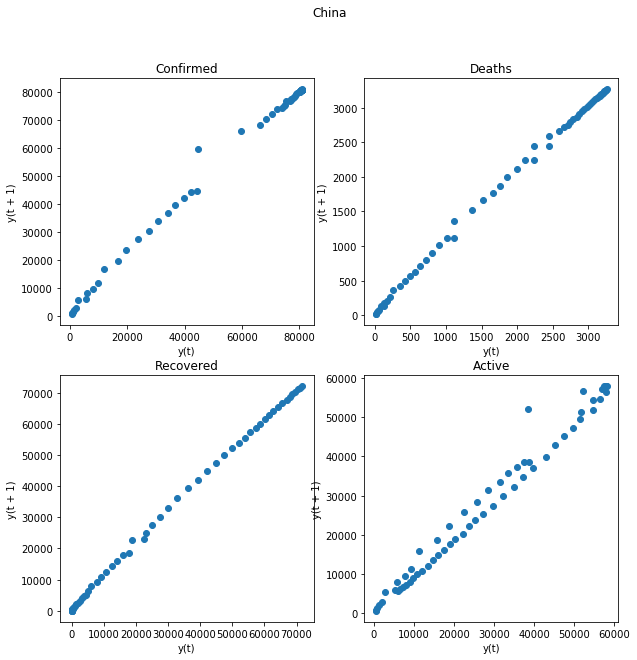

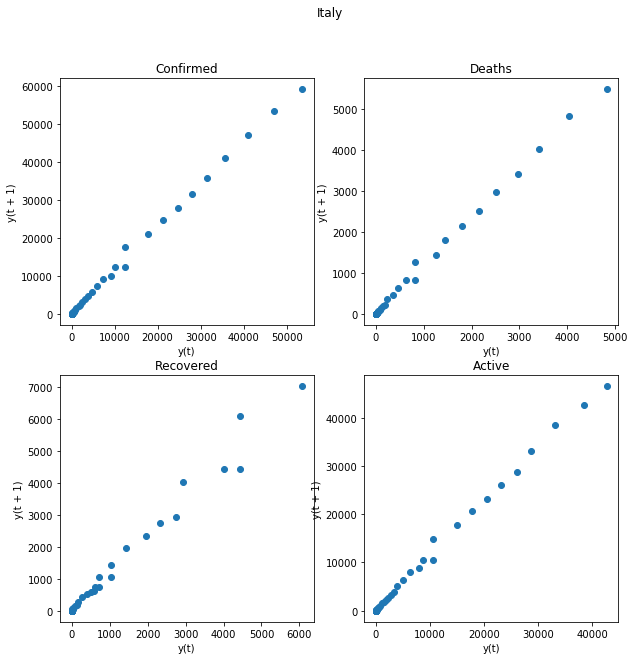

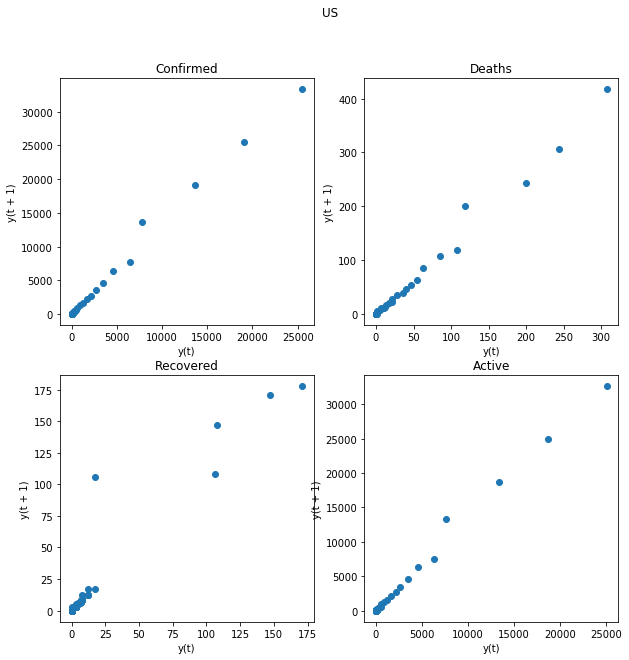

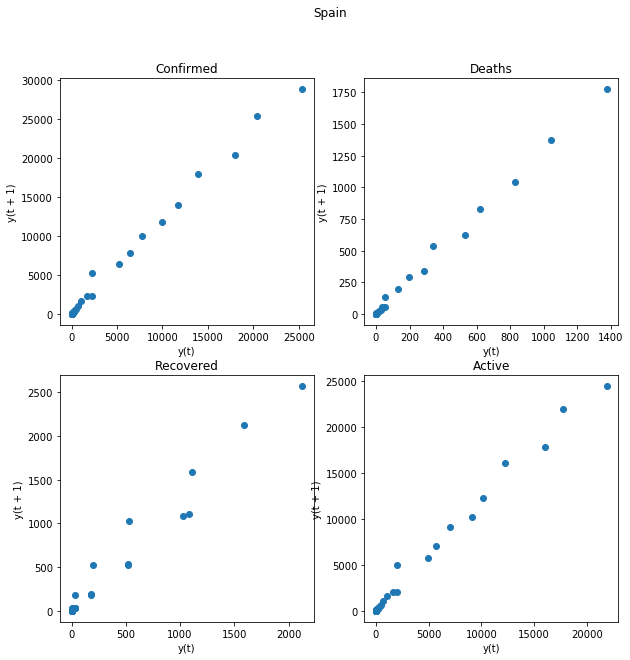

In [18]:
countries=['China','Italy','US','Spain']

for country in countries:
    data_c=df_countrymax[df_countrymax['country']==country]
    lag_plots(data_c,country,save_fig=True)


In [57]:
from datetime import datetime as dt

over='2020-02-25'
over_dt = dt.strptime(over, '%Y-%m-%d')
Italy=df[df['country']=='Italy']

In [58]:
exp_italy=Italy[Italy['date']>=over_dt][['date','confirmed']]
exp_italy['log_confirmed']=[np.log(x+1) for x in exp_italy['confirmed']]
exp_italy['date_code']=lb.fit_transform(exp_italy['date'])

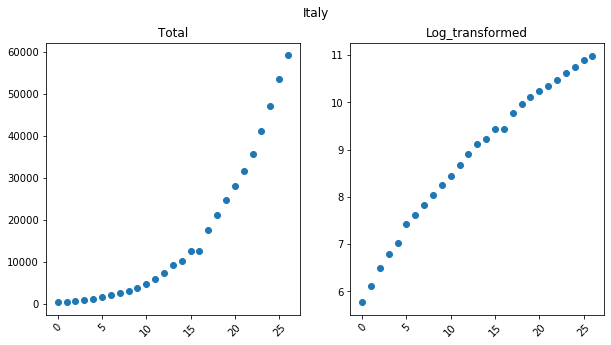

In [61]:
date=exp_italy['date_code']

plt.figure(figsize=(10,5))
plt.suptitle('Italy')
plt.subplot(121)
plt.gca().set_title('Total')
plt.scatter(date,exp_italy['confirmed'])
plt.xticks(rotation=45)
plt.subplot(122)
plt.gca().set_title('Log_transformed')
plt.scatter(date,exp_italy['log_confirmed'])
plt.xticks(rotation=45)

plt.savefig('plots\data visualization\log-tranform_italy.png')

### Define the datasets useful for the analysis

In [20]:
confirmed=df_lags[['confirmed_lag_1','confirmed_lag_2','confirmed_lag_3','confirmed_lag_4','confirmed_lag_5',
                   'confirmed_lag_6']]

In [21]:
deaths=df_lags[['deaths_lag_1','deaths_lag_2','deaths_lag_3','deaths_lag_4','deaths_lag_5','deaths_lag_6']]

In [22]:
active=df_lags[['active_lag_1','active_lag_2','active_lag_3','active_lag_4','active_lag_5','active_lag_6']]

In [23]:
data_merged=df

In [24]:
%store deaths
%store confirmed
%store active
%store data_merged

Stored 'deaths' (DataFrame)
Stored 'confirmed' (DataFrame)
Stored 'active' (DataFrame)
Stored 'data_merged' (DataFrame)
